In [1]:
# some useful mysklearn package import statements and reloads
import importlib
import os
from matplotlib import pyplot as plt

import mysklearn.myutils
importlib.reload(mysklearn.myutils)
import mysklearn.myutils as myutils

# uncomment once you paste your mypytable.py into mysklearn package
import mysklearn.mypytable
importlib.reload(mysklearn.mypytable)
from mysklearn.mypytable import MyPyTable 

# uncomment once you paste your myclassifiers.py into mysklearn package
import mysklearn.myclassifiers
importlib.reload(mysklearn.myclassifiers)
from mysklearn.myclassifiers import MyKNeighborsClassifier, MyDummyClassifier, MyNaiveBayesClassifier, MyDecisionTreeClassifier, MyRandomForestClassifier

import mysklearn.myevaluation
importlib.reload(mysklearn.myevaluation)
import mysklearn.myevaluation as myevaluation

import utils
importlib.reload(utils)
import utils as utils

In [2]:
fpath = os.path.join("Data", "beer_reviews_cleaned.csv")
table = MyPyTable().load_from_file(fpath)

## Data Analysis

### Beer Styles
We need to better understand the different values for the style of beer in order to make decisions on how to treat that attribute. If there are too many different styles, then we will need to combine similar styles. We will count the number of instances with each style and make a bar chart displaying the frequencies of each beer style.

First, we need to count the frequencies of each style. This can be done with the code.

In [3]:
styles = table.get_column("beer_style")

style_counts = {}
for style in styles:
    if style not in style_counts:
        style_counts[style] = 1
    else:
        style_counts[style] += 1


In [4]:
ratings = table.get_column("rating")

Now that the counts of all of the styles are stored in a dictionary, we can use matplotlib to create a bar chart using `plt.bar()`.

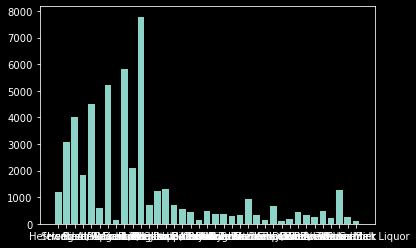

In [5]:
plt.bar(style_counts.keys(), style_counts.values())

plt.show()

## Classification

We want to test to make sure that our data can be classified. We will do this by creating multiple classifiers and testing their performance over the dataset.

First, we need to split the data into X and y. Our y attribute, or class attribute, is the rating, because we are trying to predict the rating of a beer. First, we will try to use beer_style and beer_abv as the X attributes.


In [6]:
table = table.get_columns(['beer_style', 'beer_abv', 'rating'])
table.remove_rows_with_missing_values()

X = table.get_columns(['beer_style', 'beer_abv']).data
y = table.get_column('rating')


Next, we will use stratified k-fold cross validation to train and test our classifiers with a k value of 10. This will ensure that we are testing each instance of the dataset exactly once. We are making a dummy classifier, a Naive Bayes classifier, and a decision tree classifier. We are not using a kNN classifier because the dataset is very large and it takes too long.

In [7]:
X_train_folds, X_test_folds = myevaluation.stratified_kfold_cross_validation(X, y, 10, random_state=0, shuffle=True)

dummy_y_pred = []
# knn_y_pred = []
nb_y_pred = []
dt_y_pred = []
rf_y_pred = []
y_true = []
for fold in range(len(X_train_folds)):
    X_train = [X[index] for index in X_train_folds[fold]]
    y_train = [y[index] for index in X_train_folds[fold]]
    X_test = [X[index] for index in X_test_folds[fold]]
    y_test = [y[index] for index in X_test_folds[fold]]

    dummy_clf = MyDummyClassifier()
    dummy_clf.fit(X_train, y_train)
    dummy_y_pred.extend(dummy_clf.predict(X_test))

    # knn_clf = MyKNeighborsClassifier(5)
    # knn_clf.fit(X_train, y_train)
    # knn_y_pred.extend(knn_clf.predict(X_test))

    nb_clf = MyNaiveBayesClassifier()
    nb_clf.fit(X_train, y_train)
    nb_y_pred.extend(nb_clf.predict(X_test))

    dt_clf = MyDecisionTreeClassifier()
    dt_clf.fit(X_train, y_train)
    dt_y_pred.extend(dt_clf.predict(X_test))

    rf_clf = MyRandomForestClassifier(4, 10, 2)
    rf_clf.fit(X_train, y_train)
    rf_y_pred.extend(rf_clf.predict(X_test))

    y_true.extend(y_test)

In [ ]:
labels = ["high", "low"]
pos_label = "high"

utils.measure_performance(y_true, dummy_y_pred, labels, pos_label, "Dummy")

Dummy Perfomance:
Accuracy: 0.7415739528795812
Error rate: 0.25842604712041883
Precision: 0.7415739528795812
Recall: 1.0
F1 measure: 0.851613509324064
Confusion Matrix:
        high    low    Total    Recognition %
----  ------  -----  -------  ---------------
high   36260      0    36260              100
low    12636      0    12636                0


In [ ]:
# utils.measure_performance(y_true, knn_y_pred, labels, pos_label, "KNN")

In [ ]:
utils.measure_performance(y_true, nb_y_pred, labels, pos_label, "Naive Bayes")

Naive Bayes Perfomance:
Accuracy: 0.7600212696335078
Error rate: 0.2399787303664922
Precision: 0.7860908921239268
Recall: 0.9292608935466078
F1 measure: 0.8517011273444215
Confusion Matrix:
        high    low    Total    Recognition %
----  ------  -----  -------  ---------------
high   33695   2565    36260               93
low     9169   3467    12636               27


In [ ]:
utils.measure_performance(y_true, dt_y_pred, labels, pos_label, "Decision Tree")

Decision Tree Perfomance:
Accuracy: 0.7633753272251309
Error rate: 0.2366246727748691
Precision: 0.7837409212098925
Recall: 0.9404026475455047
F1 measure: 0.8549543676662321
Confusion Matrix:
        high    low    Total    Recognition %
----  ------  -----  -------  ---------------
high   34099   2161    36260               94
low     9409   3227    12636               26


In [ ]:
utils.measure_performance(y_true, rf_y_pred, labels, pos_label, "Random Forest")

Using these attributes did not give us very good results. The decision tree had the highest accuracy with 76.3%, which is only marginally higher than the dummy classifier accuracy of 74.1%.

### Using More Attributes
Due to the poor results previously, we decided to collect more data to use. We used the Google Places API to get more data on the breweries. This is done in the file named `places_api.ipynb`. We were able to get address, price level, and rating of each brewery. This data has been combined into `joined_data.csv`.

First, we need to load in this new data.

In [ ]:
joined_path = os.path.join("Data", "joined_data.csv")
joined_table = MyPyTable().load_from_file(joined_path)

Next, we need to split the data into X and y. We will keep rating as our y attribute, but this time, we will use beer_style, beer_abv, brewery_rating, and brewery_country as the X attributes.

In [ ]:
joined_table = joined_table.get_columns(['beer_style', 'beer_abv', 'rating', 'brewery_country', 'brewery_rating'])
joined_table.remove_rows_with_missing_values()

X_2 = table.get_columns(['beer_style', 'beer_abv']).data
y_2 = table.get_column('rating')

In [ ]:
X_train_folds_2, X_test_folds_2 = myevaluation.stratified_kfold_cross_validation(X_2, y_2, 10, random_state=0, shuffle=True)

dummy_y_pred_2 = []
# knn_y_pred_2 = []
nb_y_pred_2 = []
dt_y_pred_2 = []
rf_y_pred = []
y_true_2 = []
for fold in range(len(X_train_folds_2)):
    X_train = [X_2[index] for index in X_train_folds_2[fold]]
    y_train = [y_2[index] for index in X_train_folds_2[fold]]
    X_test = [X_2[index] for index in X_test_folds_2[fold]]
    y_test = [y_2[index] for index in X_test_folds_2[fold]]

    dummy_clf = MyDummyClassifier()
    dummy_clf.fit(X_train, y_train)
    dummy_y_pred_2.extend(dummy_clf.predict(X_test))

    # knn_clf = MyKNeighborsClassifier(5)
    # knn_clf.fit(X_train, y_train)
    # knn_y_pred_2.extend(knn_clf.predict(X_test))

    nb_clf = MyNaiveBayesClassifier()
    nb_clf.fit(X_train, y_train)
    nb_y_pred_2.extend(nb_clf.predict(X_test))

    dt_clf = MyDecisionTreeClassifier()
    dt_clf.fit(X_train, y_train)
    dt_y_pred_2.extend(dt_clf.predict(X_test))

    rf_clf = MyRandomForestClassifier(4, 10, 2)
    rf_clf.fit(X_train, y_train)
    rf_y_pred.extend(rf_clf.predict(X_test))

    y_true_2.extend(y_test)

In [ ]:
labels = ["high", "low"]
pos_label = "high"

utils.measure_performance(y_true_2, dummy_y_pred_2, labels, pos_label, "Dummy")

Dummy Perfomance:
Accuracy: 0.7415739528795812
Error rate: 0.25842604712041883
Precision: 0.7415739528795812
Recall: 1.0
F1 measure: 0.851613509324064
Confusion Matrix:
        high    low    Total    Recognition %
----  ------  -----  -------  ---------------
high   36260      0    36260              100
low    12636      0    12636                0


In [ ]:
# utils.measure_performance(y_true_2, knn_y_pred_2, labels, pos_label, "KNN")

In [ ]:
utils.measure_performance(y_true_2, nb_y_pred_2, labels, pos_label, "Naive Bayes")

Naive Bayes Perfomance:
Accuracy: 0.7603484947643979
Error rate: 0.23965150523560208
Precision: 0.7856511010754691
Recall: 0.9307777164920022
F1 measure: 0.8520790729379687
Confusion Matrix:
        high    low    Total    Recognition %
----  ------  -----  -------  ---------------
high   33750   2510    36260               93
low     9208   3428    12636               27


In [ ]:
utils.measure_performance(y_true_2, dt_y_pred_2, labels, pos_label, "Decision Tree")

Decision Tree Perfomance:
Accuracy: 0.7633344240837696
Error rate: 0.2366655759162304
Precision: 0.7837309796349928
Recall: 0.9403474903474903
F1 measure: 0.8549256575483288
Confusion Matrix:
        high    low    Total    Recognition %
----  ------  -----  -------  ---------------
high   34097   2163    36260               94
low     9409   3227    12636               26


In [ ]:
utils.measure_performance(y_true, rf_y_pred, labels, pos_label, "Random Forest")